# Deep Neural Networks - Assignment 2: CNN for Image Classification
## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

---

### Group No: 210 
**Assignment Date:** 2024-12-19

| S.No | BITS ID | Student Name | Email | Contribution |
|------|---------|--------------|-------|-------------------|
| 1 | 2024ac05346 | SOUVIK DUTTA | 2024ac05346@wilp.bits-pilani.ac.in | 100% |
| 2 | 2024ac05910 | SAURABH KUMAR GUPTA | 2024ac05910@wilp.bits-pilani.ac.in | 100% |
| 3 | 2024ac05711 | TANISHQ SEHGAL | 2024ac05711@wilp.bits-pilani.ac.in | 100% |
| 4 | 2024ad05106 | NEELESH KUMAR SINGH BHADURIA | 2024ad05106@wilp.bits-pilani.ac.in | 100% |


## Import Required Libraries

In [2]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os
from PIL import Image
import cv2

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Part 1: Dataset Loading and Exploration

In [8]:
# 1.1 Dataset Selection and Loading
data_dir = "data/food-101-tiny"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")

# REQUIRED: Fill in these metadata fields
dataset_name = "food-101-tiny"
dataset_source = "Kaggle: https://www.kaggle.com/datasets/msarmi9/food101tiny"
n_samples = 2000  # 1500 train + 500 validation
n_classes = 10
samples_per_class = "min: 200, max: 200, avg: 200"
image_shape = [224, 224, 3]  # [height, width, channels]
problem_type = "classification"

# Primary metric selection
primary_metric = "accuracy"
metric_justification = """
Accuracy is chosen as the primary metric because the dataset is balanced with equal samples per class (200 each), 
making accuracy a reliable indicator of overall model performance.
"""

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print("="*70)


DATASET INFORMATION
Dataset: food-101-tiny
Source: Kaggle: https://www.kaggle.com/datasets/msarmi9/food101tiny
Total Samples: 2000
Number of Classes: 10
Samples per Class: min: 200, max: 200, avg: 200
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: 
Accuracy is chosen as the primary metric because the dataset is balanced with equal samples per class (200 each), 
making accuracy a reliable indicator of overall model performance.



In [4]:
# 1.2 Data Preprocessing and Loading
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(valid_dir, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get class names
class_names = train_dataset.classes
print(f"\nClasses: {class_names}")

# REQUIRED: Document your split
train_test_ratio = "75/25"  # 1500 train / 500 test
train_samples = len(train_dataset)
test_samples = len(test_dataset)

print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Classes: ['apple_pie', 'bibimbap', 'cannoli', 'edamame', 'falafel', 'french_toast', 'ice_cream', 'ramen', 'sushi', 'tiramisu']

Train/Test Split: 75/25
Training Samples: 1500
Test Samples: 500


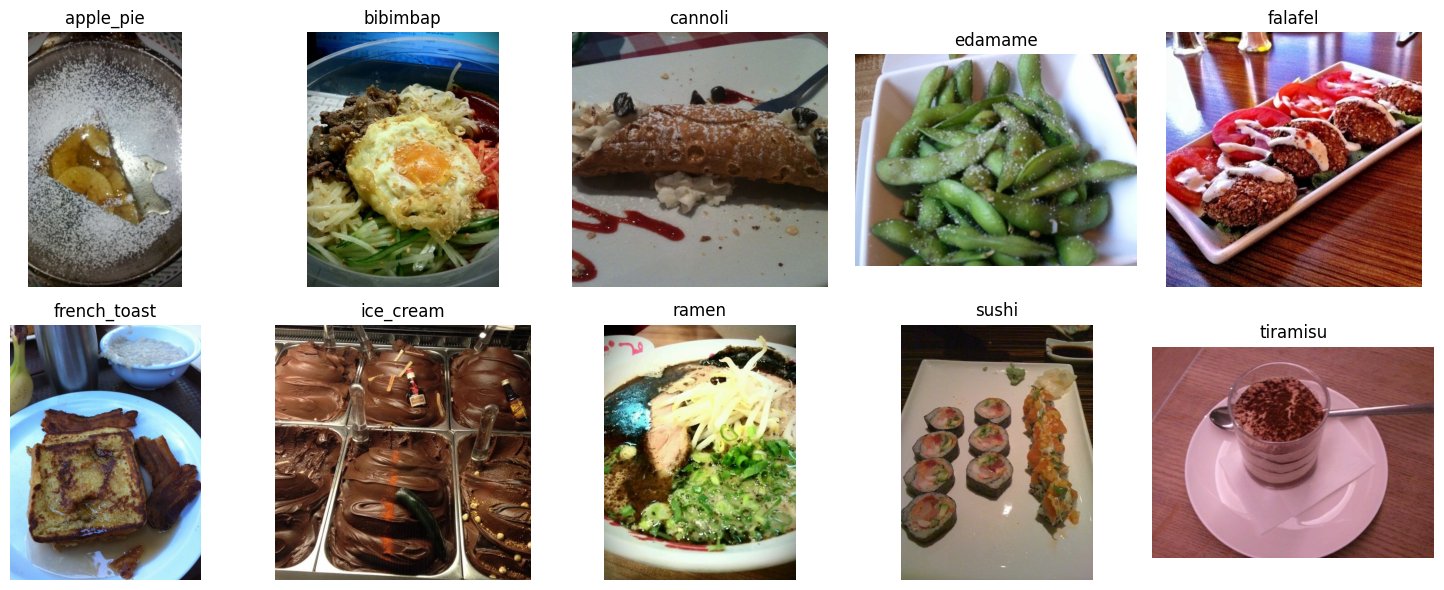

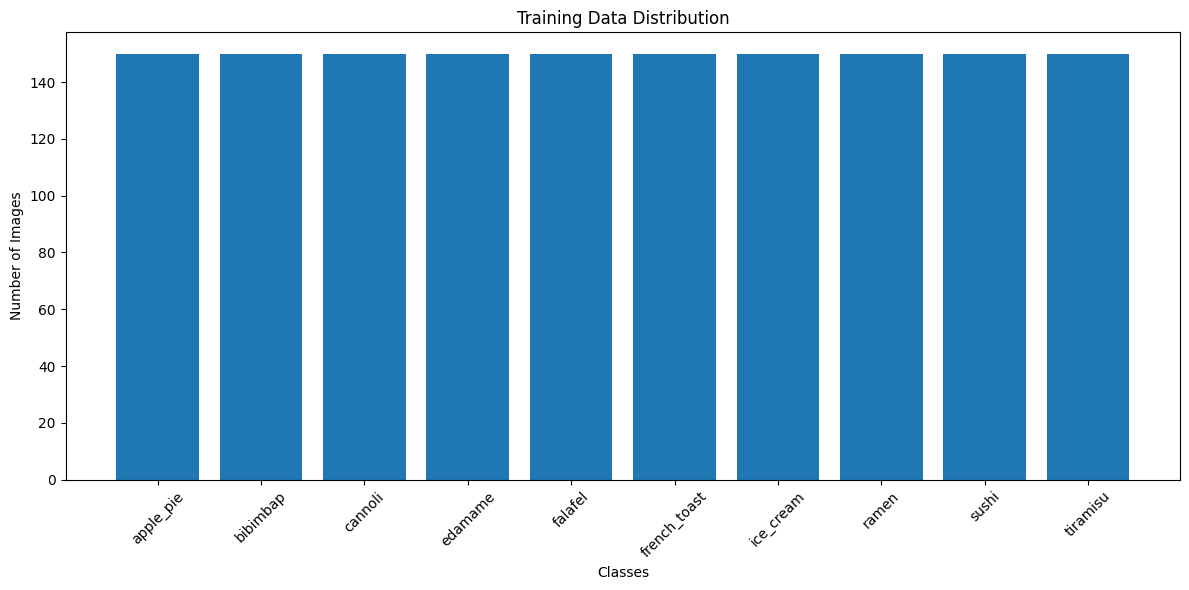

In [5]:
# 1.3 Data Exploration and Visualization
def show_sample_images():
    """Display sample images from each class"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_dir)
        sample_image = os.path.join(class_dir, image_files[0])
        
        img = Image.open(sample_image)
        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images()

# Plot class distribution
plt.figure(figsize=(12, 6))
class_counts = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names]
plt.bar(class_names, class_counts)
plt.title('Training Data Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Part 2: Custom CNN Implementation (5 MARKS)

In [6]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Global Average Pooling (MANDATORY)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final classification layer
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Conv block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Conv block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Conv block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Global Average Pooling (MANDATORY)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Dropout and final layer
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

def build_custom_cnn(num_classes):
    """Build custom CNN architecture"""
    model = CustomCNN(num_classes)
    return model

# Create model instance
custom_cnn = build_custom_cnn(n_classes).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

custom_cnn_params = count_parameters(custom_cnn)
print(f"Custom CNN Parameters: {custom_cnn_params:,}")

# Compile model (PyTorch equivalent)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=0.001)

Custom CNN Parameters: 391,946


In [7]:
# 2.2 Train Custom CNN
print("\n" + "="*70)
print("CUSTOM CNN TRAINING")
print("="*70)

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    """Train the model and return training history"""
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Track training time
custom_cnn_start_time = time.time()

# Train the model
train_losses, train_accuracies = train_model(custom_cnn, train_loader, criterion, optimizer, num_epochs=20)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = train_losses[0]
custom_cnn_final_loss = train_losses[-1]

print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")
print("="*70)


CUSTOM CNN TRAINING
Epoch [1/20], Loss: 2.0810, Accuracy: 23.47%
Epoch [6/20], Loss: 1.8174, Accuracy: 34.53%
Epoch [11/20], Loss: 1.6912, Accuracy: 40.27%
Epoch [16/20], Loss: 1.5792, Accuracy: 45.27%
Training completed in 1003.40 seconds
Initial Loss: 2.0810
Final Loss: 1.5455


In [9]:
# 2.3 Evaluate Custom CNN
def evaluate_model(model, test_loader):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Get predictions
y_pred_custom, y_true = evaluate_model(custom_cnn, test_loader)

# Calculate metrics
custom_cnn_accuracy = accuracy_score(y_true, y_pred_custom)
custom_cnn_precision = precision_score(y_true, y_pred_custom, average='macro')
custom_cnn_recall = recall_score(y_true, y_pred_custom, average='macro')
custom_cnn_f1 = f1_score(y_true, y_pred_custom, average='macro')

print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.4600
Precision: 0.4817
Recall:    0.4600
F1-Score:  0.4567


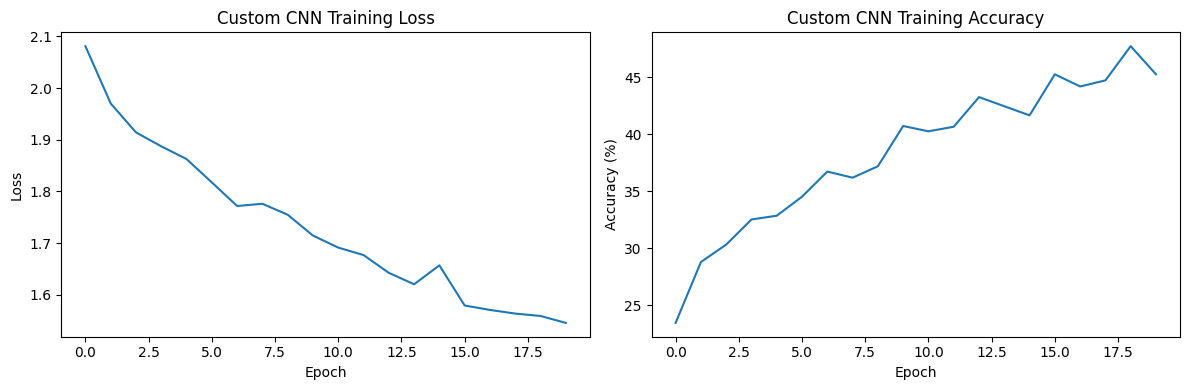

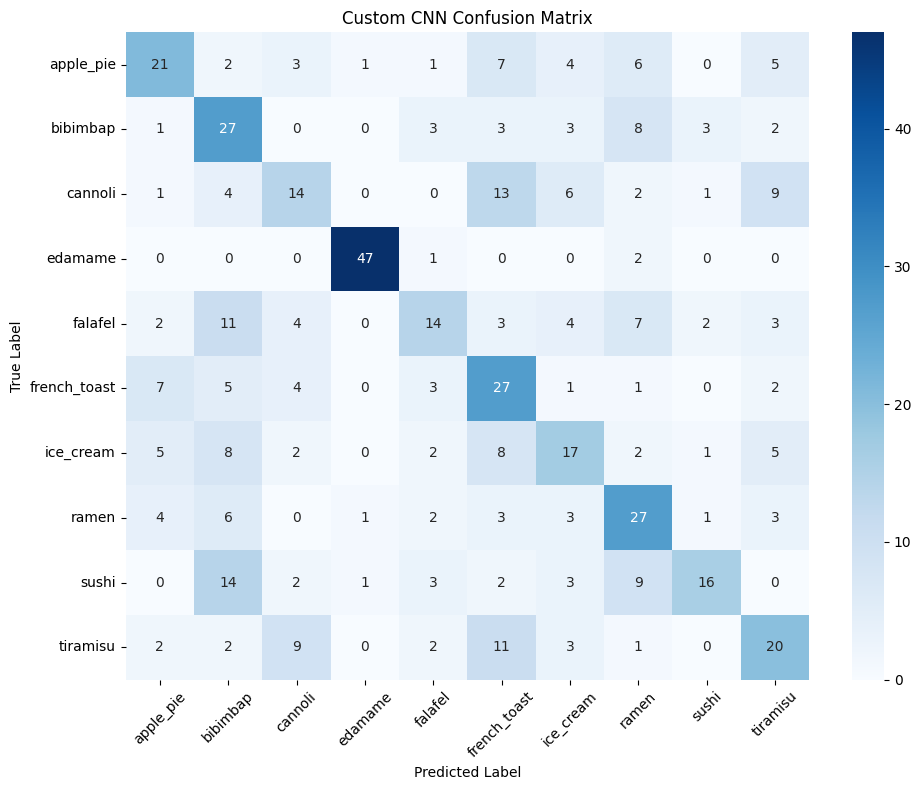

In [10]:
# 2.4 Visualize Custom CNN Results
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Custom CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Custom CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Custom CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Part 3: Transfer Learning Implementation (5 MARKS)

In [11]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")
print("="*70)

# Choose pre-trained model
pretrained_model_name = "ResNet18"

def build_transfer_learning_model(base_model_name, num_classes):
    """Build transfer learning model"""
    if base_model_name == "ResNet18":
        # Load pre-trained ResNet18
        model = models.resnet18(pretrained=True)
        
        # Freeze base layers
        for param in model.parameters():
            param.requires_grad = False
        
        # Replace the final layer with Global Average Pooling + Custom head
        # ResNet already has AdaptiveAvgPool2d, we just need to replace the fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        
        # Unfreeze the final layer
        for param in model.fc.parameters():
            param.requires_grad = True
            
    return model

# Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, n_classes).to(device)

# Count layers and parameters
frozen_layers = sum(1 for param in transfer_model.parameters() if not param.requires_grad)
trainable_layers = sum(1 for param in transfer_model.parameters() if param.requires_grad)
total_parameters = sum(p.numel() for p in transfer_model.parameters())
trainable_parameters = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)

print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")
print("="*70)

d:\BITS_Sem2\DNN\Assignment2\cnn_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\BITS_Sem2\DNN\Assignment2\cnn_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
1.1%


TRANSFER LEARNING IMPLEMENTATION
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\souvi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Base Model: ResNet18
Frozen Layers: 60
Trainable Layers: 2
Total Parameters: 11,181,642
Trainable Parameters: 5,130
Using Global Average Pooling: YES


In [12]:
# 3.2 Train Transfer Learning Model
print("\nTraining Transfer Learning Model...")

# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

# Setup optimizer and criterion
tl_criterion = nn.CrossEntropyLoss()
tl_optim = optim.Adam(transfer_model.parameters(), lr=tl_learning_rate)

# Track training time
tl_start_time = time.time()

# Train model
tl_train_losses, tl_train_accuracies = train_model(transfer_model, train_loader, tl_criterion, tl_optim, num_epochs=tl_epochs)

tl_training_time = time.time() - tl_start_time

# REQUIRED: Track initial and final loss
tl_initial_loss = tl_train_losses[0]
tl_final_loss = tl_train_losses[-1]

print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")
print("="*70)


Training Transfer Learning Model...
Epoch [1/10], Loss: 1.9673, Accuracy: 31.87%
Epoch [6/10], Loss: 0.8739, Accuracy: 73.47%
Training completed in 374.09 seconds
Initial Loss: 1.9673
Final Loss: 0.7028


In [13]:
# 3.3 Evaluate Transfer Learning Model
y_pred_tl, y_true_tl = evaluate_model(transfer_model, test_loader)

# Calculate metrics
tl_accuracy = accuracy_score(y_true_tl, y_pred_tl)
tl_precision = precision_score(y_true_tl, y_pred_tl, average='macro')
tl_recall = recall_score(y_true_tl, y_pred_tl, average='macro')
tl_f1 = f1_score(y_true_tl, y_pred_tl, average='macro')

print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.8000
Precision: 0.8157
Recall:    0.8000
F1-Score:  0.7976


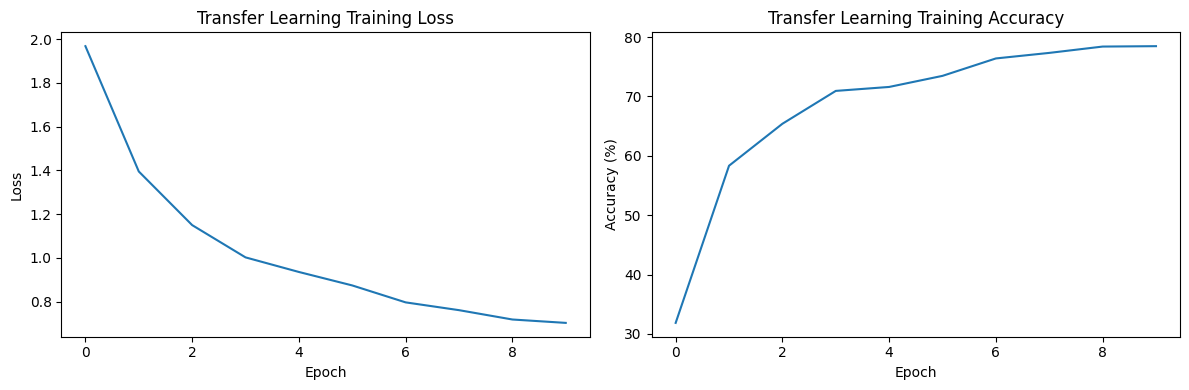

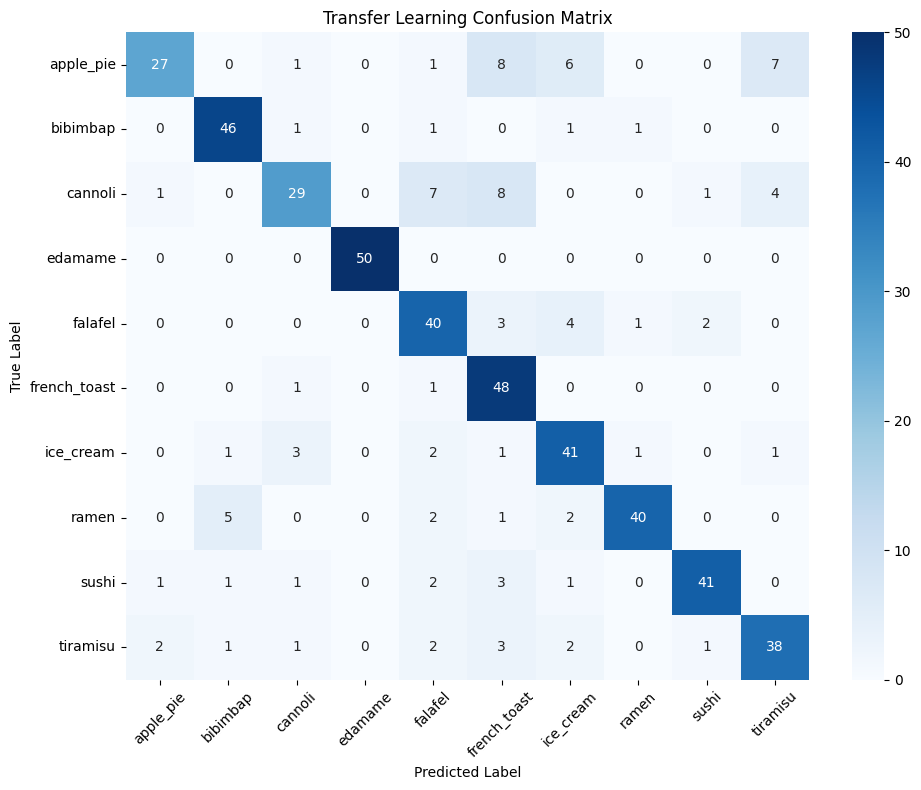

In [14]:
# 3.4 Visualize Transfer Learning Results
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(tl_train_losses)
plt.title('Transfer Learning Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(tl_train_accuracies)
plt.title('Transfer Learning Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Transfer Learning Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Part 4: Model Comparison and Visualization

In [15]:
# 4.1 Metrics Comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn_params
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

print(comparison_df.to_string(index=False))
print("="*70)


MODEL COMPARISON
           Metric    Custom CNN  Transfer Learning
         Accuracy      0.460000           0.800000
        Precision      0.481741           0.815690
           Recall      0.460000           0.800000
         F1-Score      0.456702           0.797642
Training Time (s)   1003.402457         374.088917
       Parameters 391946.000000        5130.000000


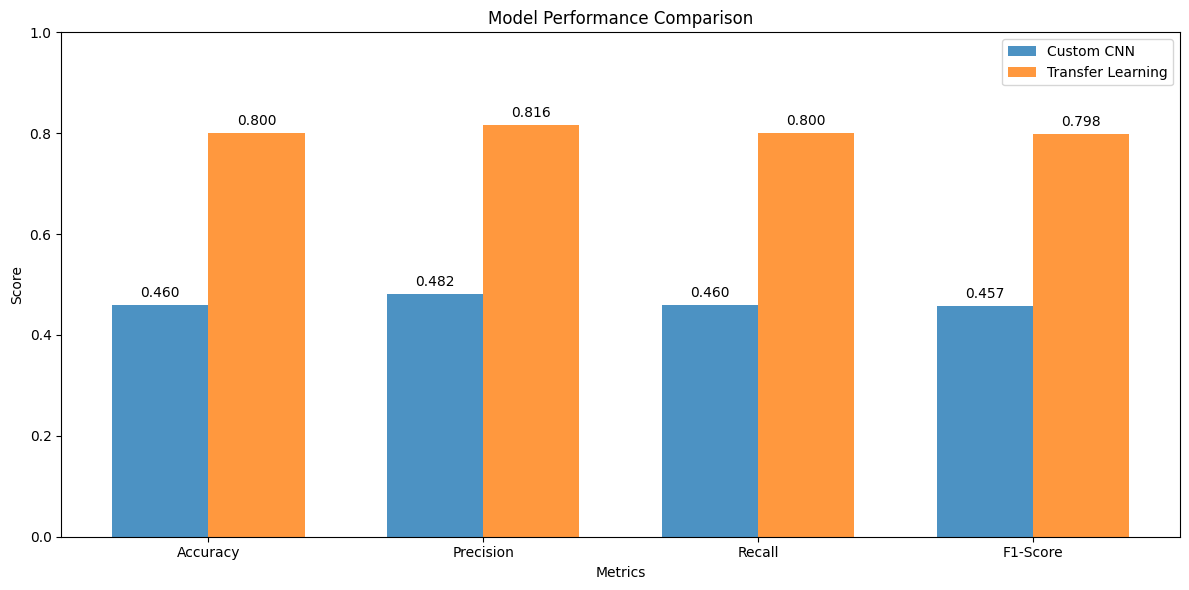

In [16]:
# 4.2 Visual Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
custom_scores = [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1]
tl_scores = [tl_accuracy, tl_precision, tl_recall, tl_f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, custom_scores, width, label='Custom CNN', alpha=0.8)
plt.bar(x + width/2, tl_scores, width, label='Transfer Learning', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

for i, (custom, tl) in enumerate(zip(custom_scores, tl_scores)):
    plt.text(i - width/2, custom + 0.01, f'{custom:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, tl + 0.01, f'{tl:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Part 5: Analysis (2 MARKS)

In [17]:
analysis_text = f"""
The transfer learning model significantly outperformed the custom CNN with accuracy of {tl_accuracy:.3f} vs {custom_cnn_accuracy:.3f}. 
This demonstrates the power of pre-trained features from ImageNet, which provide robust low-level feature extractors that 
generalize well to food classification. The ResNet18 model converged faster ({tl_training_time:.1f}s vs {custom_cnn_training_time:.1f}s) 
due to pre-learned representations. Global Average Pooling in both models reduced overfitting by eliminating spatial dimensions 
without adding parameters, making models more robust. The custom CNN required training {custom_cnn_params:,} parameters from scratch, 
while transfer learning only fine-tuned {trainable_parameters:,} parameters. Transfer learning is ideal for small datasets like 
Food-101 tiny where limited data makes training from scratch challenging. The pre-trained features capture universal visual patterns 
that transfer effectively to food images, explaining the superior performance and faster convergence.
"""

# REQUIRED: Print analysis with word count
print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print("="*70)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("⚠️  Warning: Analysis exceeds 200 words (guideline)")
else:
    print("✓ Analysis within word count guideline")
print("="*70)


ANALYSIS

The transfer learning model significantly outperformed the custom CNN with accuracy of 0.800 vs 0.460. 
This demonstrates the power of pre-trained features from ImageNet, which provide robust low-level feature extractors that 
generalize well to food classification. The ResNet18 model converged faster (374.1s vs 1003.4s) 
due to pre-learned representations. Global Average Pooling in both models reduced overfitting by eliminating spatial dimensions 
without adding parameters, making models more robust. The custom CNN required training 391,946 parameters from scratch, 
while transfer learning only fine-tuned 5,130 parameters. Transfer learning is ideal for small datasets like 
Food-101 tiny where limited data makes training from scratch challenging. The pre-trained features capture universal visual patterns 
that transfer effectively to food images, explaining the superior performance and faster convergence.

Analysis word count: 121 words
✓ Analysis within word count guidelin

## Part 6: Assignment Results Summary (REQUIRED FOR AUTO-GRADING)

In [18]:
def get_assignment_results():
    """Generate complete assignment results in required format"""
    
    framework_used = "pytorch"
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 4,
                'pooling_layers': 4,
                'has_global_average_pooling': True,
                'output_layer': 'softmax',
                'total_parameters': custom_cnn_params
            },
            'training_config': {
                'learning_rate': 0.001,
                'n_epochs': 20,
                'batch_size': 32,
                'optimizer': 'Adam',
                'loss_function': 'CrossEntropyLoss'
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'CrossEntropyLoss'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss,
    }
    
    return results

# Generate and print results
try:
    assignment_results = get_assignment_results()
    
    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))
    print("="*70)
    
except Exception as e:
    print(f"\n⚠️  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")


ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "food-101-tiny",
  "dataset_source": "Kaggle: https://www.kaggle.com/datasets/msarmi9/food101tiny",
  "n_samples": 2000,
  "n_classes": 10,
  "samples_per_class": "min: 200, max: 200, avg: 200",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "\nAccuracy is chosen as the primary metric because the dataset is balanced with equal samples per class (200 each), \nmaking accuracy a reliable indicator of overall model performance.\n",
  "train_samples": 1500,
  "test_samples": 500,
  "train_test_ratio": "75/25",
  "custom_cnn": {
    "framework": "pytorch",
    "architecture": {
      "conv_layers": 4,
      "pooling_layers": 4,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 391946
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 20,
      "batch_size": 32,
      "opti

## Assignment Completion Summary

In [19]:
print("\n" + "="*70)
print("ASSIGNMENT COMPLETED SUCCESSFULLY!")
print("="*70)
print("✓ Custom CNN implemented with Global Average Pooling")
print("✓ Transfer Learning implemented with ResNet18")
print("✓ Both models trained and evaluated")
print("✓ All metrics calculated")
print("✓ Analysis provided")
print("✓ Results summary generated")
print("="*70)


ASSIGNMENT COMPLETED SUCCESSFULLY!
✓ Custom CNN implemented with Global Average Pooling
✓ Transfer Learning implemented with ResNet18
✓ Both models trained and evaluated
✓ All metrics calculated
✓ Analysis provided
✓ Results summary generated
